### Laboratory work 6 - Analysis of accuracy decrease of tracking in conditions of biased state noise
#### Abramov Semen, Belikov Ilia, Nikolay Zherdev, Mikhail Kulbeda
#### Skoltech, 14.10.2018

The objective of this laboratory work is to analyze the sensitivity of estimation results obtained by a Kalman filter that doesn’t take into account bias of state and measurement noise. This will bring about a deeper understanding of main difficulties of practical Kalman filter implementation and skills to overcome these difficulties to get optimal assimilation output.

This laboratory work consists of one part:
I. Divergence of Kalman filter when bias of state noise (acceleration) is neglected in assimilation algorithm. Development of optimal Kalman filter that takes into account bias of state noise (acceleration).

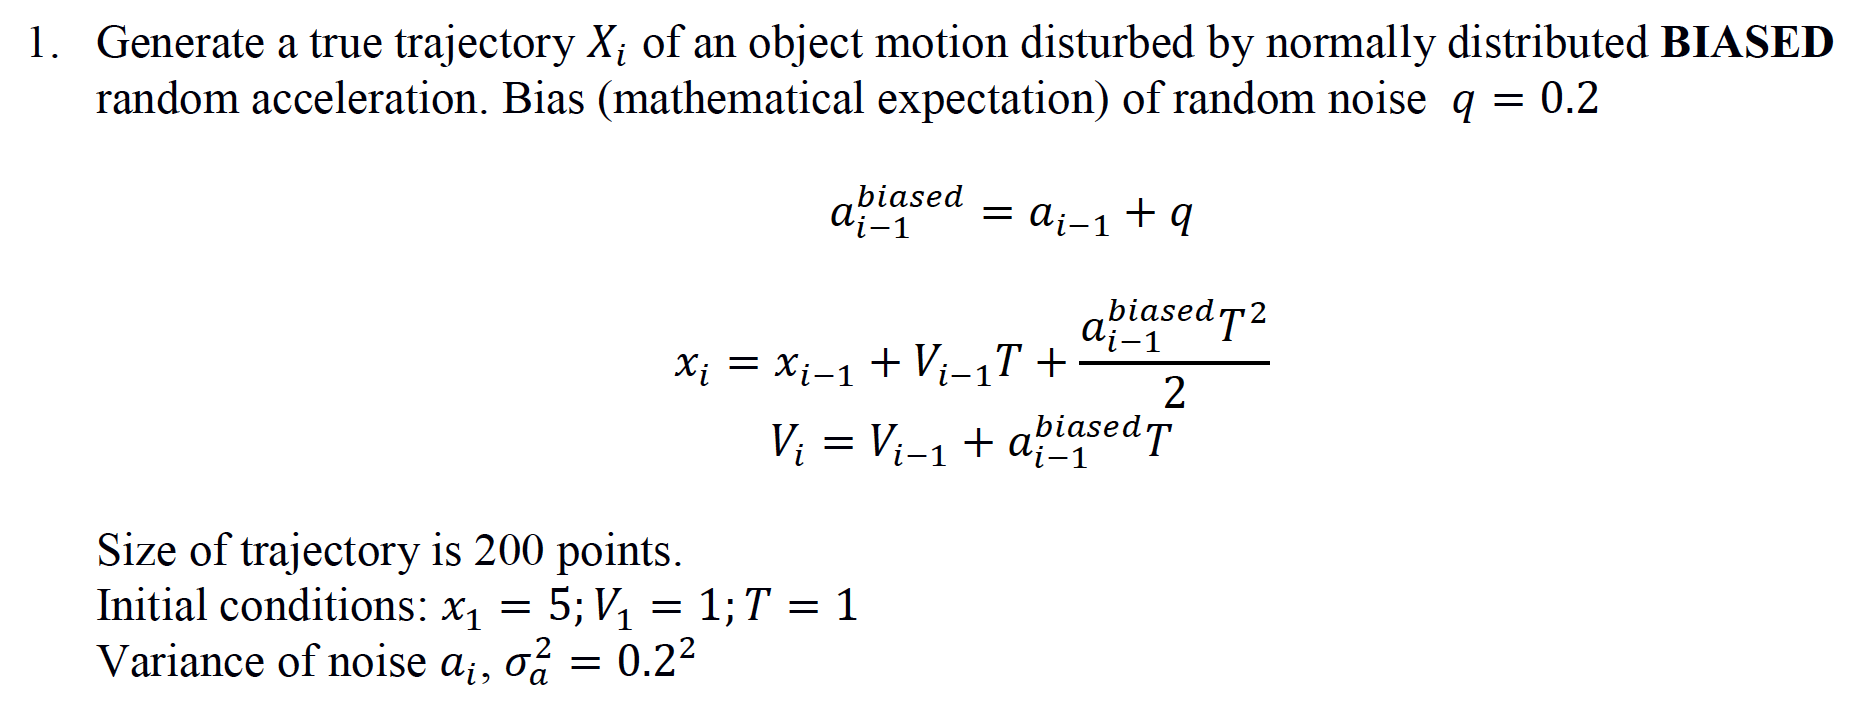

In [26]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from sklearn.metrics import mean_squared_error


init_notebook_mode(connected=True)

In [27]:
# T = 1
# mean = 0.2
# var = 0.2**2
# steps = 200
# accels = np.random.normal(loc = mean, scale = np.sqrt(var), size = steps)
# velocity = np.zeros(steps)
# velocity[1:] = accels[:-1]*T
# velocity = np.cumsum(velocity)

In [28]:
data = [
    go.Scatter(
        y=accels,
        name='accelerations biased'
    ),
#     go.Scatter(
#         y=velocity,
#         name='velocity'
#     ),
]

layout= go.Layout(
    title= 'Kalman filter in assumption of unbiased acceleration',
    xaxis= dict(
        title= 'Step',
    ),
    yaxis=dict(
        title= 'X',
    ),
    showlegend= True
)
fig= go.Figure(data=data, layout=layout)
iplot(fig)

In [29]:
# Accelerated motion
def generate_biased_trajectory(X0 = 5, V0 = 1, T = 1, mean = 0.2, var = 0.2**2, steps = 200):

    velocity = np.zeros(steps)
    velocity[0] = V0
    accels = np.random.normal(loc = mean, scale = np.sqrt(var), size = steps)
    velocity[1:] = accels[:-1]*T
    velocity = np.cumsum(velocity)
    
    X = np.zeros(steps)
    X[0] = X0
    X[1:] = velocity[:-1]*T + accels[:-1]*(T**2)/2
    return np.cumsum(X)

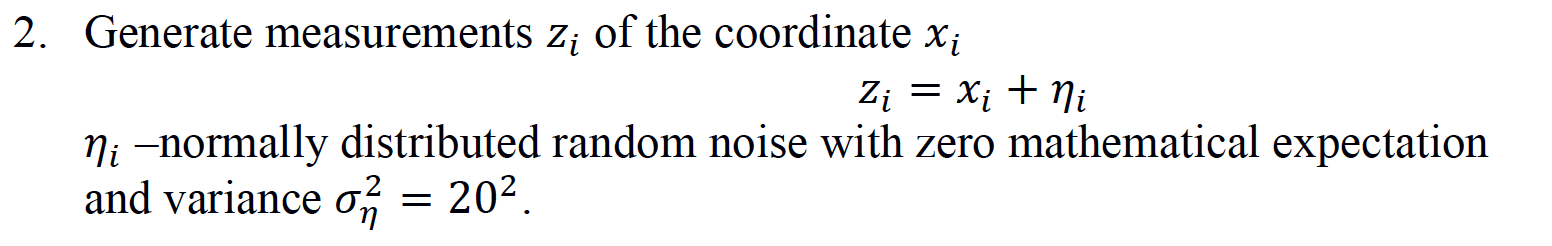

In [30]:
def measure(trajectory, mean = 0, var = 20**2):
    noise = np.random.normal(loc = mean, scale = np.sqrt(var), size = trajectory.shape)
    return np.add(trajectory, noise)

In [31]:
tr_biased = generate_biased_trajectory(X0 = 5, V0 = 1, T = 1, mean = 0.2, var = 0.2**2, steps = 200)
msr = measure(tr_biased, var = 20**2) # array Nx1

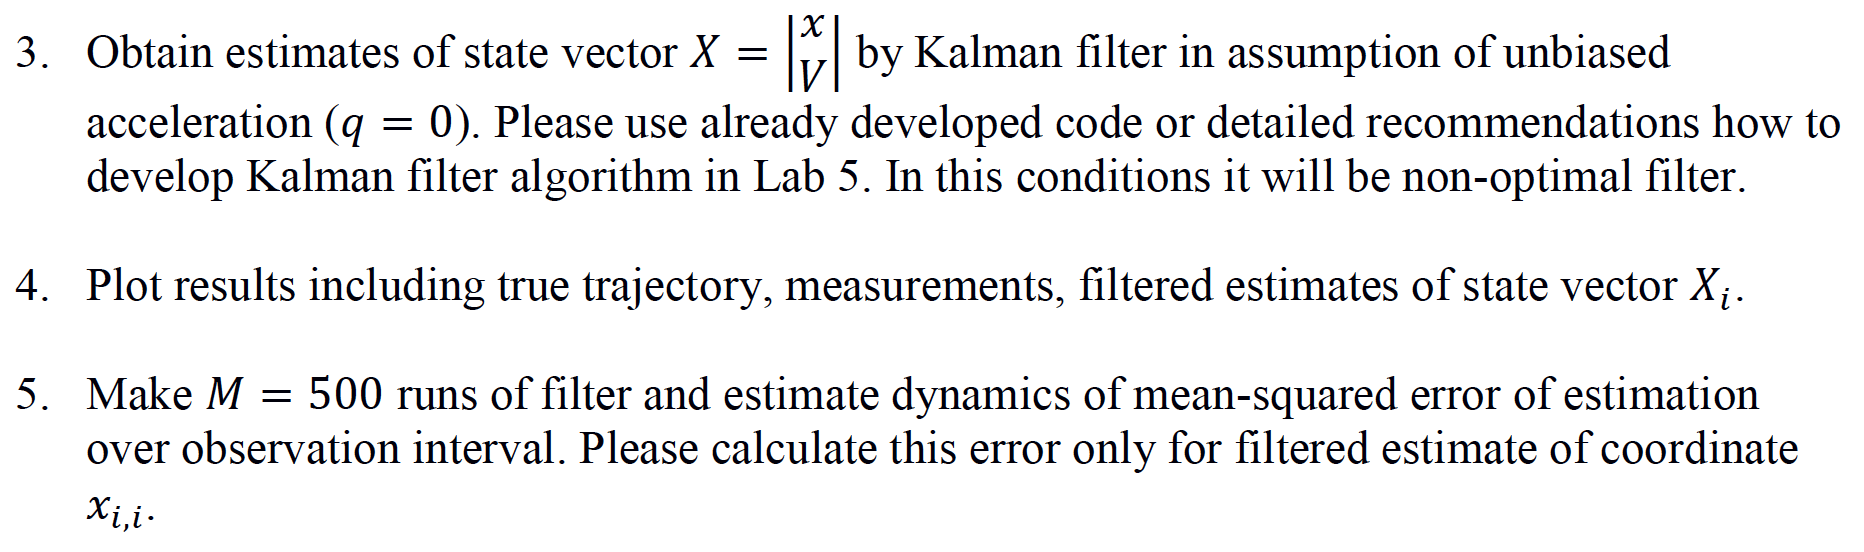

We presume that initial filtered estimate is [2.0, 0]. 

In [32]:
def kalman_unbiased(msr, T = 1, X_init = [2.0, 0], P_init = [[10000, 0], [0, 10000]], var_a = 0.2**2, var_n = 20**2):
    
    size = (len(msr), 2) # size of array
    G = np.array([T**2/2, T]).T
    Q = G.dot(G.T.dot(var_a))
    R = var_n
    F = np.array([[1, T], [0, 1]])
    H = np.array([1, 0])
    X = np.zeros(size)
    X_ = np.zeros(size)
    P = np.zeros((size[0], 2, 2))
    P_ = np.zeros((size[0], 2, 2))
    K = np.zeros(size) 
    
    X_[0] = X_init
    P_[0] = P_init
    
    for k in range(1, size[0]):
        
        # Prediction
        X[k] = np.dot(F, X_[k-1])
        P[k] = np.dot(F, np.dot(P_[k-1], F.T)) + Q
        
        # Update
        K[k] = np.dot(P[k], H.T)/(np.dot(H, np.dot(P[k], H.T)) + R)
        X_[k] = X[k] + K[k]*(msr[k] -  np.dot(H, X[k]))
        P_[k] = np.dot((np.eye(2) - np.outer(K[k], H)), P[k])   
    
    return X[:,0], X_[:,0], K[:,0], np.sqrt(P[:,0,0]), np.sqrt(P_[:,0,0]), np.linalg.matrix_power(F,7).dot(X_.T)[0]

In [33]:
X_predicted, X_filtered, K, P_predicted, P_filtered, X7 = kalman_unbiased(msr, T = 1, P_init = [[10000, 0], [0, 10000]], var_a = 0.2**2)

In this experiment we 500 times generate traj with math expectation of noise = 0.2 (biased) and estimate the error with unbiased Kalman filtered (that doesn't take into account bias of noise)

In [34]:
def experiment2(runs = 500, steps = 200, P_init = [[10000, 0], [0, 10000]], mean = 0.2, X_init = [2.0, 0], var_a = 0.2**2, var_n = 20**2):
    error_e = np.zeros(steps)
    error_f = np.zeros(steps)
    
    for i in range(runs):
        
        tr_biased = generate_biased_trajectory(X0 = 5, V0 = 1, T = 1, mean = mean, var = var_a, steps = steps)
        msr = measure(tr_biased, var = var_n)
        X_predicted, X_filtered, K, P_predicted, P_filtered, X7 = kalman_unbiased(msr, P_init = P_init, var_a = 0.2**2)
        
        error_e += (X_filtered - tr_biased)**2
        #error_f += (X7 - tr_biased)**2
        
    error_e = np.sqrt(error_e/(runs-1))
    #error_f = np.sqrt(error_f/(runs-1))

    return error_e #, error_f

In [35]:
error_e = experiment2()

In [42]:
data = [
#     go.Scatter(
#         y=P_filtered[2:],
#         name='filtration error cov matr P'
#     ),
#     go.Scatter(
#         y=error_e[2:],
#         name='estimation error'
#     ),
    go.Scatter(
        y=tr_biased,
        name='true traj'
    ),
    go.Scatter(
        y=msr,
        name='measurements'
    ),
    go.Scatter(
        y=X_filtered,
        name='Kalman filtered'
    ),
]

layout= go.Layout(
    title= 'Kalman filter in assumption of unbiased acceleration',
    xaxis= dict(
        title= 'Step',
    ),
    yaxis=dict(
        title= 'X',
    ),
    showlegend= True
)
fig= go.Figure(data=data, layout=layout)
iplot(fig)

In [43]:
data = [
    go.Scatter(
        y=P_filtered[2:],
        name='filtration error cov matr P'
    ),
    go.Scatter(
        y=error_e[2:],
        name='estimation error'
    ),
#     go.Scatter(
#         y=tr_biased,
#         name='true traj'
#     ),
#     go.Scatter(
#         y=msr,
#         name='measurements'
#     ),
#     go.Scatter(
#         y=X_filtered,
#         name='Kalman filtered'
#     ),
]

layout= go.Layout(
    title= 'Kalman filter in assumption of unbiased acceleration',
    xaxis= dict(
        title= 'Step',
    ),
    yaxis=dict(
        title= 'X',
    ),
    showlegend= True
)
fig= go.Figure(data=data, layout=layout)
iplot(fig)

This final error is true error of estimation as we used true trajectory to get this error. As we can see estimation error stays around 18 due to not taking into account bias of noise. I also checked how much would be the error with bias = 0.3 and the estimation error in this case changed to ~26. It looks like bias of noise just influences static error.

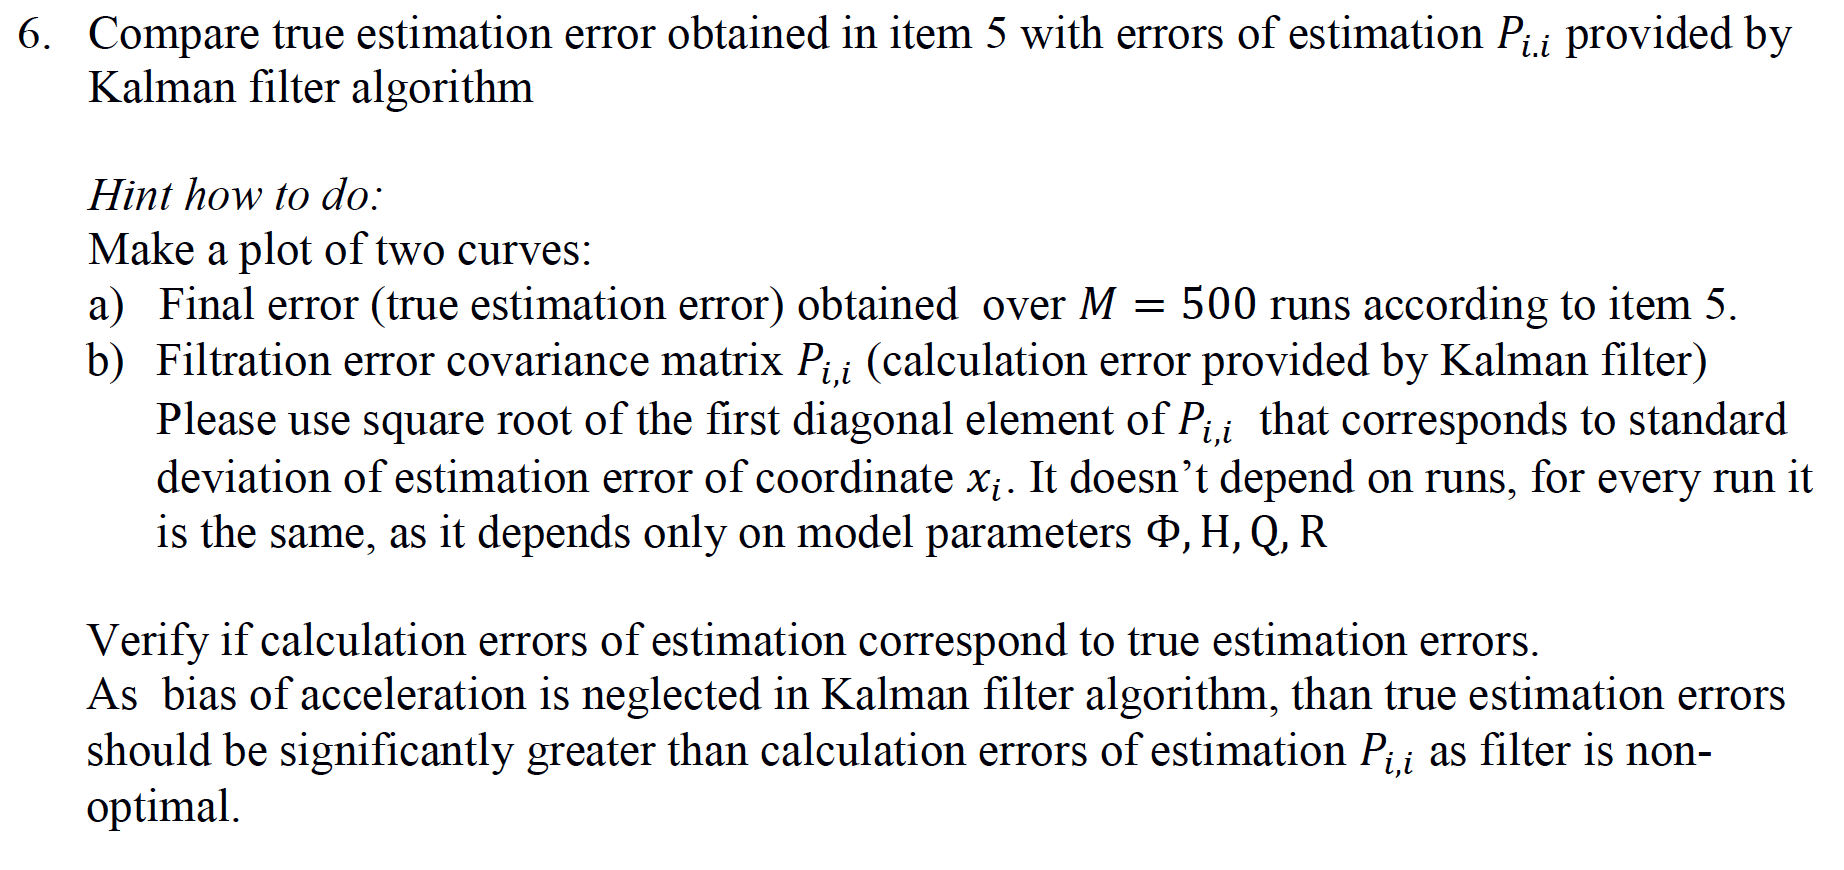

(plot is above) Indeed, true estimation errors are greater than calculation errors of estimation Pi.

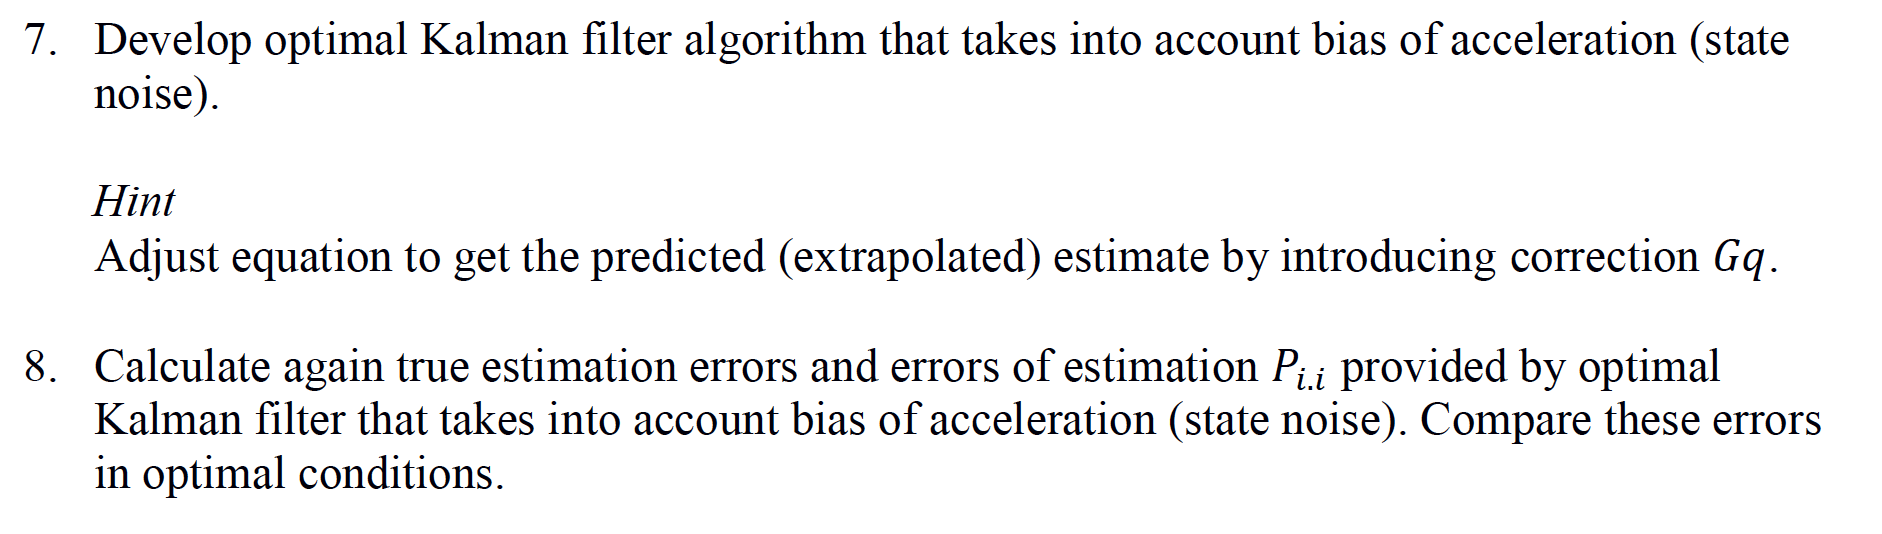

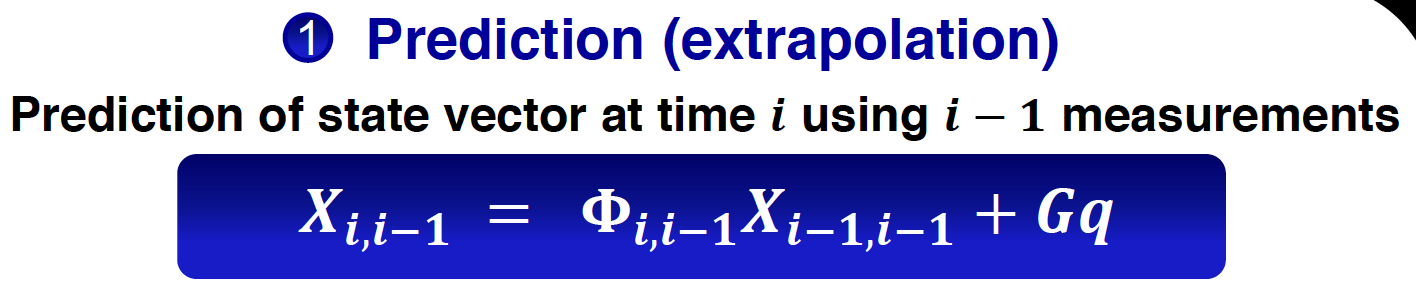

In [ ]:
# T = 1
# G = np.array([T**2/2, T]).T
# q = 0.2
# print(G, G*q)

Here we introduce correction Gq in prediction equation X

In [37]:
def kalman(measr, T = 1, X_init = [2.0, 0], P_init = [[10000, 0], [0, 10000]], var_a = 0.2**2, var_n = 20**2, q = 0.2):
    
    size = (len(measr), 2) # size of array
    G = np.array([T**2/2, T]).T
    Q = G.dot(G.T.dot(var_a))
    R = var_n
    F = np.array([[1, T], [0, 1]])
    H = np.array([1, 0])
    X = np.zeros(size)
    X_ = np.zeros(size)
    P = np.zeros((size[0], 2, 2))
    P_ = np.zeros((size[0], 2, 2))
    K = np.zeros(size) 
    
    X_[0] = X_init
    P_[0] = P_init
    
    for k in range(1, size[0]):
        
        # Prediction
        X[k] = np.dot(F, X_[k-1]) + G*q
        #X[k] = np.dot(F, X_[k-1])

        P[k] = np.dot(F, np.dot(P_[k-1], F.T)) + Q
        
        # Update
        K[k] = np.dot(P[k], H.T)/(np.dot(H, np.dot(P[k], H.T)) + R)
        X_[k] = X[k] + K[k]*(measr[k] -  np.dot(H, X[k]))
        P_[k] = np.dot((np.eye(2) - np.outer(K[k], H)), P[k])   
    
    return X[:,0], X_[:,0], K[:,0], np.sqrt(P[:,0,0]), np.sqrt(P_[:,0,0]), np.linalg.matrix_power(F,7).dot(X_.T)[0]

In this experiment we 500 times generate biased_trajectory and use Kalman filter, which takes into account noise of state.

In [38]:
def experiment3(runs = 500, steps = 200, P_init = [[10000, 0], [0, 10000]], mean = 0.2, X_init = [2.0, 0], var_a = 0.2**2, var_n = 20**2):
    error_e = np.zeros(steps)
    error_f = np.zeros(steps)
    
    for i in range(runs):
        
        tr_biased = generate_biased_trajectory(X0 = 5, V0 = 1, T = 1, mean = mean, var = var_a, steps = steps)
        msr = measure(tr_biased, var = var_n)
        X_predicted, X_filtered, K, P_predicted, P_filtered, X7 = kalman(msr, T = 1, P_init = P_init, var_a = var_a)
        
        error_e += (X_filtered - tr_biased)**2
        #error_f += (X7 - tr_biased)**2
        
    error_e = np.sqrt(error_e/(runs-1))
    #error_f = np.sqrt(error_f/(runs-1))

    return error_e #, error_f

Here we generate true biased traj and estimate it with normal Kalman filter in order to compare the results

In [39]:
tr_biased = generate_biased_trajectory(X0 = 5, V0 = 1, T = 1, mean = 0.2, var = 0.2**2, steps = 200)
msr = measure(tr_biased, var = 20**2)
_, X_filtered, _, _, P_filtered, _ = kalman(msr)

In [40]:
error_e_opt = experiment3(mean = 0.2)

In [44]:
data = [
    go.Scatter(
        y=P_filtered[2:],
        name='filtration error cov matr P'
    ),
    go.Scatter(
        y=error_e[2:],
        name='estimation error - non-opt'
    ),
    go.Scatter(
        y=error_e_opt[2:],
        name='estimation error - opt'
    ),
#     go.Scatter(
#         y=tr_biased[2:],
#         name='true biased traj'
#     ),
#     go.Scatter(
#         y=msr[2:],
#         name='measured'
#     ),
#     go.Scatter(
#         y=X_filtered[2:],
#         name='X_filtered - opt'
#     ),
]

layout= go.Layout(
    title= 'Kalman filter in assumption of unbiased acceleration',
    xaxis= dict(
        title= 'Step',
    ),
    yaxis=dict(
        title= 'X',
    ),
    showlegend= True
)
fig= go.Figure(data=data, layout=layout)
iplot(fig)

Now the estimation error is around 7.5 which is more than two times less than before.
So taking into account bias of noise reduces the estimation error.